In [ ]:
import cv2
import math
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import json
import glob
import os
import dlib
import imutils
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import model_from_json
from keras.utils import np_utils
from imutils import face_utils
from google.colab.patches import cv2_imshow
import traceback
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if (os.getcwd() != "/content/drive/My Drive/TestVideos/TextLinkFiles"):
  os.chdir("/content/drive/My Drive/TestVideos/TextLinkFiles")
  print("change path to TextLinkFiles")
else:
  print("already in TextLinkFiles")

change path to TextLinkFiles


In [ ]:
!ls

academyAwards.txt    hair.txt			  restaurants.txt
BicepsCurl.txt	     humanHairColor.txt		  SamWinchester.txt
billboard.txt	     LordVoldemort.txt		  serve.txt
chapel.txt	     movieclips.txt		  theHobbit.txt
CNBC.txt	     movielinks.txt		  theTwilightSaga.txt
CNET.txt	     musicVideos.txt		  trailer.txt
Cornet.txt	     NBA2K14.txt		  vampire.txt
deanWinchester.txt   NBA2K15.txt		  VaticanCity.txt
flamenco.txt	     newscaster.txt		  whiteHouse.txt
football.txt	     newsProgram.txt		  WWE12.txt
groceryStore.txt     phantomOfTheOpera.txt	  WWE13.txt
hairColoring.txt     preacher.txt		  WWE2K15.txt
hairConditioner.txt  presidentOfUnitedStates.txt  WWE2K24.txt
hairRemoval.txt      president.txt		  WWE2K.txt
hairstyle.txt	     redHair.txt		  WWEAllStars.txt


In [ ]:
try:
  import youtube_dl
  !youtube-dl --list-formats https://youtu.be/sVs5_nbdxVo
  !youtube-dl --format 160 --get-url https://youtu.be/sVs5_nbdxVo
  !ffplay -i $(youtube-dl --format 160 --get-url https://youtu.be/sVs5_nbdxVo)
  print("successfully import")
except:
  print("*****************")
  print("installing youtube_dl now....")
  !pip install --upgrade youtube_dl
  import youtube_dl
  print("imported")

[youtube] sVs5_nbdxVo: Downloading webpage
[youtube] sVs5_nbdxVo: Downloading MPD manifest
[info] Available formats for sVs5_nbdxVo:
format code  extension  resolution note
139          m4a        audio only DASH audio   49k , m4a_dash container, mp4a.40.5@ 48k (22050Hz)
249          webm       audio only DASH audio   50k , webm_dash container, opus @ 50k (48000Hz)
250          webm       audio only DASH audio   67k , webm_dash container, opus @ 70k (48000Hz)
251          webm       audio only DASH audio  121k , webm_dash container, opus @160k (48000Hz)
140          m4a        audio only DASH audio  129k , m4a_dash container, mp4a.40.2@128k (44100Hz)
278          webm       256x144    DASH video   95k , webm_dash container, vp9, 30fps, video only
160          mp4        256x144    DASH video  108k , mp4_dash container, avc1.4d400b, 30fps, video only
242          webm       426x240    DASH video  220k , webm_dash container, vp9, 30fps, video only
133          mp4        426x240    DASH 

In [ ]:
# download youtube url
def retry_download_pytube(url):
  try:
    # set up library
    video_url = url
    try:
      import pytube
      from pytube import YouTube
    except:
      !pip install pytube3
      import pytube
      from pytube import YouTube
    # start getting video
    os.chdir("/content/drive/My Drive/TestVideos/DownloadedVideos")
    targetVideo = YouTube(video_url)
    first_v = targetVideo.stream.first()
    first_v.download()
    print("download pytube video successfully")
    video_links = []
    # for v in glob.glob("/content/drive/My Drive/TestVideos/DownloadedVideos/*.mp4"):
    #   video_links.append(v)
    #   print("glob mp4 in pytube download")
    # if the file downloaded wasn't in mp4 format
    if not video_links:
      for vi in glob.glob("/content/drive/My Drive/TestVideos/DownloadedVideos/*"):
        video_links.append(vi)
        print("glob other files in pytube download")
    return video_links 
  except:
    print("fail pytube download,empty list []")
    traceback.print_exc()
    empty = []
    return empty


In [ ]:
# some files might not allow extracting info(i.e. title, format etc), glob file names and pass to outer function to process
def retry_download_youtubedl(url):
  try:
    video_links = []
    os.chdir("/content/drive/My Drive/TestVideos/DownloadedVideos")
    ydl_opts = {"ext":"webm","resolution":"360p"}
    ydl = youtube_dl.YoutubeDL(ydl_opts)
    
    ydl.download([url])
    for video in glob.glob("/content/drive/My Drive/TestVideos/DownloadedVideos/*"):
      video_links.append(video)
      print("glob "+ video +"  in youtubedl download")
    # empty list will return if not grabing 
    return video_links
  except:
    print("fail youtube-dl download, empty list []")
    traceback.print_exc()
    return video_links

In [ ]:
# def retry_using_pafy(url):
#   try: 
#     print(url)

#     try:
#       import pafy
#     except:
#       !pip install pafy
#       import pafy
#       print("using pafy to load youtube Videos")

#     # creating pafy object of the video
#     video = pafy.new(url)
#     # getting stream at index 0
#     best = video.streams[0]
#     # cap = cv.VideoCapture(best.url)
#     print("isOpen:"+ str(cap.isOpened()) +" ")
#   except:
#     # # url of the video
#     # url = "https://youtu.be/sVs5_nbdxVo"
#     traceback.print_exc()
#     print("exception caught")

    

In [ ]:
def delete_downloaded_videos():
  try:
    pathlist = glob.glob("/content/drive/My Drive/TestVideos/DownloadedVideos/*")
    count = len(pathlist)
    for p in pathlist:
      os.remove(p)
    print("deleted "+ str(count) + "videos.")
  except:
    traceback.print_exc()

In [ ]:
def delete_angry_videos():
  try:
    pathlist = glob.glob("/content/drive/My Drive/TestVideos/Videos/Angry/*.avi")
    count = len(pathlist)
    for p in pathlist:
      os.remove(p)
    print("remove "+ str(count) +" existing videos in Angry folder.")
  except:
    traceback.print_exc()

In [ ]:
def set_video_cap(curr_url):
  # level 1
  try:
    indicator = 0
    video_url = curr_url
    ydl_opts = {}
    try:
      ydl_opts = {"resolution":"360p/240p"}
      ydl = youtube_dl.YoutubeDL(ydl_opts)
      info_dict = ydl.extract_info(video_url,download=False)
      formats = info_dict.get("formats",None)
      print(formats)
    except:
      return cv2.VideoCapture(curr_url),1
    url = ""
    fp = 0
    wid = 0
    hgt = 0
    ext = ""
    vcode = ""
    fid = ""
    playl = ""
    container = ""
    # for f in formats:
    #   # if f.get("ext",None) == "mp4":

    #   url = f.get("url",None)
    #   fp = f.get("fps",None)
    #   wid = f.get("width",None)
    #   hgt = f.get("height",None)
    #   ext = f.get("ext",None)
    #   vcode = f.get("vcodec",None)
    for f in formats:
      print("this format_notes: " + f.get("format_note",None) + "  this format vcodec:" + f.get("vcodec",None))
      if (f.get("format_note",None) == "360p") and (f.get("ext",None) == "webm") and (f.get("vcodec",None) == "vp9" or f.get("vcodec",None) == "none"):
        url = f.get("url",None)
        print("get 360p, youtubed-l: "+url)
        fp = f.get("fps",None)
        wid = f.get("width",None)
        hgt = f.get("height",None)
        ext = f.get("ext",None)
        vcode = f.get("vcodec",None)
        playl = f.get("playlist",None)
        container = f.get("container",None)
        fid = f.get("format_id",None)
        indicator = 0
        break
    # 
    if (url == ""):
      for f in formats:
        if ((f.get("format_note",None) == "240p") and (f.get("ext",None) == "webm")) and (f.get("vcodec",None) == "vp9" or f.get("vcodec",None) == "none"):
          url = f.get("url",None)
          print("get 240p, youtubed-l: "+url)
          fp = f.get("fps",None)
          wid = f.get("width",None)
          hgt = f.get("height",None)
          ext = f.get("ext",None)
          vcode = f.get("vcodec",None)
          playl = f.get("playlist",None)
          container = f.get("container",None)
          fid = f.get("format_id",None)
          indicator = 0
          break
    
    if (url == ""):
      for f in formats:
        if ((f.get("format_note",None) == "144p") and (f.get("ext",None) == "webm")) and (f.get("vcodec",None) == "vp9" or f.get("vcodec",None) == "none"):
          url = f.get("url",None)
          print("get 144p, youtubed-l: "+url)
          fp = f.get("fps",None)
          wid = f.get("width",None)
          hgt = f.get("height",None)
          ext = f.get("ext",None)
          vcode = f.get("vcodec",None)
          playl = f.get("playlist",None)
          container = f.get("container",None)
          fid = f.get("format_id",None)
          indicator = 0
          break
      
    if (url == ""):
      indicator = 1

    print("fp:"+str(fp) + " width:"+str(wid) + " height:" + str(hgt) + " ext:"+str(ext) + " vcodec:"+str(vcode) +" format_id:" + str(fid) + " container:" + str(container) + " playlist:" + str(playl))
    cap = cv2.VideoCapture(url)
    
    # close level 1 cap
    if not cap.isOpened():
      cap.release() # release cap1
      print("cap not opened - try level2 - d")
      # level 2 cap
      try:
        vlist = []
        vlist = retry_download_youtubedl(video_url)
        # if vlist is empty
        if (not vlist) or (len(vlist) ==0):
          print("no downloaded videos")
          return cv2.VideoCapture(url),1 # might return null, ----------------------- change needed
        else:
            print("more than one video exist")
            print("print vlist:")
            print(vlist)
            print()
            vlist.sort(key=os.path.getctime)
            print("vlist len:"+str(len(vlist))+" get:"+ str(vlist[-1]))
            cap2 = cv2.VideoCapture(vlist[-1])
            # # remove all
            # delete_downloaded_videos()
            if not cap2.isOpened():
              print("cannot open cap2 - d")
              return cap2,1
            else:
              print("success at level 2 - d")
              return cap2,2
         
      except:
        print("fail at level 2 - d")
        traceback.print_exc()
        return cap2,1
        
    else: # if video open when youtubedl
      print("success, level 1")
      print("success, return 0")
      return cap,0

  except: # level 2
    cap.release()
    print("exception - try level2 - p")
    traceback.print_exc()
    try:
      plist = []
      plist = retry_download_pytube(video_url)
      if (not plist) or (len(plist) ==0):
        print("no downloaded videos")
        return cv2.VideoCapture(video_url),1
      else: # may combine !=1 and 1
          print("more than one video exist. Read latest")
          print("print plist")
          print(plist)
          print()
          # by latest creation date
          plist.sort(key=os.path.getctime)
          # read latest
          print("len plist:"+ str(len(plist))+ " get:" + str(plist[-1]))
          cap2 = cv2.VideoCapture(plist[-1])
          # # remove all
          # delete_downloaded_videos()
          if not cap2.isOpened():
            print("cannot open cap2 - p")
            return cap2,1
          else:
            print("success at level 2 - p")
            return cap2,2
    except: 
      print("fail at level 2 - p")
      traceback.print_exc()
      return cap2,1


In [ ]:
def detect_parts(image,detector,predictor):
  try:
    distances = []
    image = imutils.resize(image,width=200,height=200)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    rects = detector(gray,1)

    for (i,rect) in enumerate(rects):
      # print(i)
      shape = predictor(gray,rect)
      shape = face_utils.shape_to_np(shape)
      distances = euclidean_all(shape)
  except:
    traceback.print_exc()
    raise RuntimeError("throw in detect_parts")
  return distances


In [ ]:
def euclidean_all(a):
  try:
    distances = ""
    for i in range(0,len(a)):
      
      for j in range(0,len(a)):
        dist = euclidean(a[i],a[j])
        dist = "%.2f" % dist;
        distances = distances + " " + str(dist)
  except:
    traceback.print_exc()
    raise RuntimeError("throw in euclidean all()")
  return distances

In [ ]:
def euclidean(a,b):
  dist = math.sqrt(math.pow((b[0]-a[0]),2) + math.pow((b[1]-a[1]),2))
  return dist

In [ ]:
def set_folder(foldercount):
  try:
    newfolder = "/content/drive/My Drive/TestVideos/Frames/"+str(foldercount)
    if not os.path.exists(newfolder):
      print("folder doesn't exist, make new folder to store")
      os.makedirs(newfolder)
      print("make new directory:"+newfolder)
    else:
      files = glob.glob(newfolder+"/*")
      for f in files:
        os.remove(f)
        print("delete:"+f)
      print("all images removed. clean " + newfolder)
  except:
    traceback.print_exc()
    print("fail at create new folder")
    raise RuntimeError()

In [ ]:
# function to write to folder
def write_to_folder(framecounter,image,foldercount):
  try:
    image_write_path = "/content/drive/My Drive/TestVideos/Frames"+"/" + str(foldercount) + "/" + str(framecounter) + ".jpg"
    
    cv2.imwrite(image_write_path,image)
    print("written "+image_write_path)
  except:
    print("caught in write_to_folder")
    traceback.print_exc()
    raise RuntimeError("throw in write_to_folder")

In [ ]:
def set_video_output(emotiontype,vcount):
  try:
    filename = "/content/drive/My Drive/TestVideos/Videos/" + emotiontype + "/" + str(vcount) + ".avi"
    # filename = "/content/drive/My Drive/TestVideos/Videos/" + emotiontype + "/" + str(vcount) + ".mp4"
    # codec = cv2.VideoWriter_fourcc(*"MPEG")
    codec = cv2.VideoWriter_fourcc("X","V","I","D")
    # codec = cv2.VideoWriter_fourcc("D","I","V","X")
    # codec = cv2.VideoWriter_fourcc("M","J","P","G")
    # codec = cv2.VideoWriter_fourcc("m","p","4","v")
    # framerate = 24
    # resolution = (256,144)
    final_video = cv2.VideoWriter(filename,codec,5,(630,360),True)
    isopen = final_video.isOpened()
    print("check, it should be open:" + str(isopen))
  except:
    print("\n caught in set_video_output")
    traceback.print_exc()
    return final_video,False
    # raise RuntimeError("throw in set_video_output")
  print("exit set_video_output")
  return final_video,isopen

In [ ]:
def set_video_output2(emotiontype,vcount,codec):
  try:
    filename = "/content/drive/My Drive/TestVideos/Videos/" + emotiontype + "/" + str(vcount) + ".mp4"
    # filename = "/content/drive/My Drive/TestVideos/Videos/" + emotiontype + "/" + str(vcount) + ".mkv"
    # codec = cv2.VideoWriter_fourcc(*"mp4v")
    # codec = cv2.VideoWriter_fourcc("H","2","6","4")
    final_video = cv2.VideoWriter(filename,int(codec),5,(630,360),True)
    isopen = final_video.isOpened()
    print("check, it should be open:" + str(isopen))
    
  except:
    print("\n caught in set_video_output")
    traceback.print_exc()
    return final_video,False
    # raise RuntimeError("throw in set_video_output")
  print("exit set_video_output")
  return final_video,isopen

In [ ]:
def img_to_video(foldernum):
  try:
    print("write imgs to videos")
    img_array = []
    imgpath = "/content/drive/My Drive/TestVideos/Frames/"+str(foldernum)+"/*"
    imgfs = glob.glob(imgpath)
    print("glob:")
    print(imgfs)
    if not imgfs:
      print("list is empty. No angry faces found")
      return
    for f in imgfs:
        img = cv2.imread(f)
        height, width, layers = img.shape
        size = (width,height)
        print("before resize:"+str(img.shape))
        imgresize = cv2.resize(img,(630,360))
        print("after resize:"+str(imgresize.shape))
        img_array.append(imgresize)
        
    
    os.chdir("/content/drive/My Drive/TestVideos/imgVideos")
    out = cv2.VideoWriter((str(foldernum)+'.avi'),cv2.VideoWriter_fourcc(*'DIVX'), 5, (630,360))
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    print("finish writing.release")
    out.release()
  except:
    traceback.print_exc()
    if out.isOpened():
      out.close()
    raise RuntimeError("exception in img_to_video")

In [ ]:
def testResults(par_emotion,vcount,counterframe,curr_url,emotions,detector,predictor,model,face_cascade):
  cap,indicator = set_video_cap(curr_url) #return cap of the youtube video, if indicator ==1, something wrong, release
  if indicator == 1:
    print("vcount:"+ str(vcount) + ", release!")
    cap.release()
    return
  else:
    try:
      print("cap info:")
      cc = cap.get(cv2.CAP_PROP_FOURCC)
      print( "FOURCC code" + str(cc))
      # print("format:" + str(cap.get(cv2.CAP_PROP_FORMAT)) )
      video_out = None
      openOutV = False
      print("indicator:"+str(indicator))

      # check indicator
      if indicator == 2: # image won't requre video out
        # print("case 2. Set images, write to images")
        # set_folder(vcount)
        # test case 2 *******************************
        print("case 2 still write to video test")
        video_out,openOutV = set_video_output(par_emotion,vcount)
        #*******************************************************
      else:
        print("case 1, set video")
        video_out,openOutV = set_video_output(par_emotion,vcount)
      
      # check if output file normal
      if (openOutV == False) and (indicator != 2): # images won't requre videout
        print("output video problem, exit.")
        cap.release()
        video_out.release()
      else:
        print("continue, output video is fine")
        # test case 2 **************************
        if openOutV == False:
          print("not opened, release")
          cap.release()
          video_out.release()
        # *****************************************

      
      framecount = 0
      while(True):
        ret, img = cap.read()
        if ret == True:
          gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
          faces = face_cascade.detectMultiScale(gray,1.3,5)
          facecount = 0
          
          for (x,y,w,h) in faces:
            facecount += 1
            if (facecount >3):
              break
            # cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # put color box around face
            detected_face = img[int(y):int(y+h),int(x):int(x+w)]
            distances = detect_parts(detected_face,detector,predictor)
            if (len(distances)!=0):
              val = distances.split(" ")[1:]
              val = np.array(val)
              val = val.astype(np.float)
              val = np.expand_dims(val,axis=1)
              minmax = preprocessing.MinMaxScaler()
              val = minmax.fit_transform(val)
              val = val.reshape(1,4624)
              #predict
              predictions = model.predict(val)
              
              # most likely emotion chosen
              indx = np.argmax(predictions[0])
              emotiontype = emotions[indx]
         
              if (emotiontype == par_emotion):
                cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
                framecount += 1
                print("before resize:"+str(img.shape))
                imgresize = cv2.resize(img,(630,360))
                print("after resize:"+str(imgresize.shape))
                # write image to jpg if cannot open
                if (indicator == 2):

                  # print("write to image")
                  # write_to_folder(framecount,imgresize,vcount)

                  # test case 2****************************************
                  video_out.write(imgresize)
                  #*****************************************
                else:
                  print("write to video")
                  video_out.write(imgresize) # write to video
                cv2_imshow(img)
                print("found,break forloop")
                break # do not look at other faces in the image if an angry face is found
                # print("Angry: %",predictions[0][0] *100)
                # print("Disgust: %",predictions[0][1] * 100)
                # print("Fear: %",predictions[0][2] * 100)
                # print("Happy: %",predictions[0][3] * 100)
                # print("Neutral: %",predictions[0][4] * 100)
                # print("Sad: %",predictions[0][5] * 100)
                # print("Surprise: %",predictions[0][6] * 100)
                # cv2.putText(img,par_emotion,(int(x),int(y)),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
                
              else:
                continue
              
        else:
          print("frame not returned. False. close video output and cap")
          if indicator == 2:
            print("cap:"+str(cap.isOpened()))
            cap.release()
            print("cap:"+ str(cap.isOpened()))

            # print("generate a video from images...")
            # img_to_video(vcount)
            # print("finish writing")

            # test case 2 *****************8
            
            print("video_Out: " + str(video_out.isOpened()))
            video_out.release()
            print("video_out:"+str(video_out.isOpened()))
            # ****************************8*

            break
          else:
            print("video_Out: " + str(video_out.isOpened()))
            video_out.release()
            print("video_out:"+str(video_out.isOpened()))
            print("cap:"+str(cap.isOpened()))
            cap.release()
            print("cap:"+ str(cap.isOpened()))
           
            break
    except:
      # print("caught in testResult(),close output and cap")
      if indicator == 2:
        traceback.print_exc()
        cap.release()
        raise RuntimeError("caught in testResult(),close output and cap")
      else:
        traceback.print_exc()
        video_out.release()
        cap.release()
        raise RuntimeError("caught in testResult(),close output and cap")
    # normal exit
    
    if cap.isOpened():
      cap.release()
    else:
      print("cap is closed")

    # if indicator != 2: # ***** test 2 *****
    if video_out.isOpened():
      print("opened , release videoOUT")
      video_out.release()
    else:
        print("video_out is close")


In [ ]:
def main():
  movielinkfile = open("/content/drive/My Drive/TestVideos/TextLinkFiles/CNET.txt","r")
  clips = movielinkfile.readlines()
  list_of_links = []
  for x in clips:
    list_of_links.append(str(x.strip("\n").replace("//y","https://www.y")))
  # print("links are:")
  # print("."+list_of_links[0]+".")
  emotions = ("Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise")
  detector = dlib.get_frontal_face_detector() # detect face using dlib's model
  predictor = dlib.shape_predictor("/content/drive/My Drive/TestVideos/shape_predictor_68_face_landmarks.dat") # return facial landmarks
  # prepare for model
  openjson = open("/content/drive/My Drive/CK_JAFFE_model/mstruc.json","r")
  model_structure = openjson.read()
  openjson.close()
  # restore model
  model = model_from_json(model_structure)
  model.load_weights("/content/drive/My Drive/CK_JAFFE_model/mweights.h5")
  os.chdir("/content/drive/My Drive/TestVideos")
  tf.keras.utils.plot_model(model, to_file="m3.png", show_shapes=True)
  # opencv
  face_cascade = cv2.CascadeClassifier("/content/drive/My Drive/TestVideos/haarcascade_frontalface_default.xml")
  # counters
  counterframe = 0
  video_count = 0
  print("set up facial landmark detector, loaded model and weights, set up face detector, set up counters")
  for i in range(0,len(list_of_links)):
  # for i in range(10,len(list_of_links)): #len(list_of_links)
    print("Number # " + str(i) + "video below.")
    print("video format info:")
    #!youtube-dl -F https://www.youtube.com/watch?v=B4kR4787TQQ
    print("others:")
    temp = list_of_links[i]
    print("link at the beginning before processing"+str(temp))
    # templink = "https://www.youtube.com/watch?v=90vUFwUp6mw"
    # testResults(par_emotion,vcount,counterframe,curr_url,emotions,detector,predictor,model,facecascade):
    delete_downloaded_videos()
    testResults("Angry",i,counterframe,temp,emotions,detector,predictor,model,face_cascade)
    print("link at the end after processing:"+str(temp))
    

remove 0 existing videos in Angry folder.
set up facial landmark detector, loaded model and weights, set up face detector, set up counters
Number # 0video below.
video format info:
others:
link at the beginning before processinghttps://www.youtube.com/watch?v=Cy1uQLYijp8
deleted 1videos.
[youtube] Cy1uQLYijp8: Downloading webpage
[youtube] Cy1uQLYijp8: Downloading MPD manifest
[{'ext': 'm4a', 'format_note': 'DASH audio', 'acodec': 'mp4a.40.5', 'abr': 48, 'container': 'm4a_dash', 'format_id': '139', 'manifest_url': 'https://manifest.googlevideo.com/api/manifest/dash/expire/1609554057/ei/KYTvX8mKAcfEhwbCtongAQ/ip/34.86.29.206/id/0b2d6e40b6228e9f/source/youtube/requiressl/yes/playback_host/r4---sn-p5qlsns6.googlevideo.com/mh/0d/mm/31%2C29/mn/sn-p5qlsns6%2Csn-p5qs7nee/ms/au%2Crdu/mv/m/mvi/4/pl/20/hfr/all/as/fmp4_audio_clear%2Cwebm_audio_clear%2Cwebm2_audio_clear%2Cfmp4_sd_hd_clear%2Cwebm2_sd_hd_clear/initcwndbps/2071250/vprv/1/mt/1609532195/fvip/4/keepalive/yes/itag/0/sparams/expire%2Cei%2

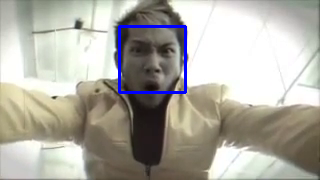

found,break forloop
before resize:(180, 320, 3)
after resize:(360, 630, 3)


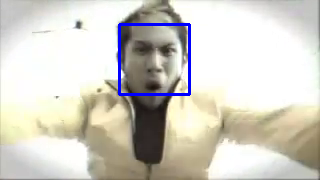

found,break forloop
before resize:(180, 320, 3)
after resize:(360, 630, 3)


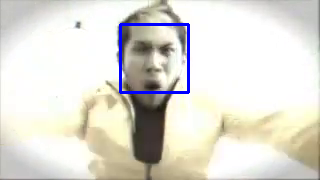

found,break forloop
before resize:(180, 320, 3)
after resize:(360, 630, 3)


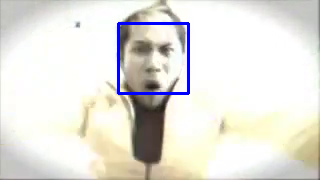

found,break forloop
before resize:(180, 320, 3)
after resize:(360, 630, 3)


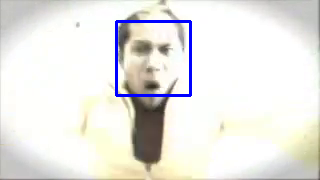

found,break forloop
frame not returned. False. close video output and cap
cap:True
cap:False
video_Out: True
video_out:False
cap is closed
video_out is close
link at the end after processing:https://www.youtube.com/watch?v=Cy1uQLYijp8
Number # 1video below.
video format info:
others:
link at the beginning before processinghttps://www.youtube.com/watch?v=1WyWvhPHPWI
deleted 1videos.
[youtube] 1WyWvhPHPWI: Downloading webpage
[youtube] 1WyWvhPHPWI: Downloading MPD manifest
[{'ext': 'm4a', 'format_note': 'DASH audio', 'acodec': 'mp4a.40.5', 'abr': 48, 'container': 'm4a_dash', 'format_id': '139', 'manifest_url': 'https://manifest.googlevideo.com/api/manifest/dash/expire/1609554202/ei/uYTvX47KNo6Dhwa8wJDICw/ip/34.86.29.206/id/d56c96be13c73d62/source/youtube/requiressl/yes/playback_host/r6---sn-p5qs7n7z.googlevideo.com/mh/1J/mm/31%2C29/mn/sn-p5qs7n7z%2Csn-p5qlsnzd/ms/au%2Crdu/mv/m/mvi/6/pl/20/hfr/all/as/fmp4_audio_clear%2Cwebm_audio_clear%2Cwebm2_audio_clear%2Cfmp4_sd_hd_clear%2Cwebm2_sd_hd_

[dashsegments] Total fragments: 74
[download] Destination: Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.f298.mp4
[download] 100% of 92.80MiB in 00:30
[dashsegments] Total fragments: 38
[download] Destination: Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.f251.webm
[download] 100% of 7.18MiB in 00:09
[ffmpeg] Merging formats into "Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.mkv"
Deleting original file Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.f298.mp4 (pass -k to keep)
Deleting original file Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.f251.webm (pass -k to keep)
glob /content/drive/My Drive/TestVideos/DownloadedVideos/Apple Byte - Apple Byte - The 'iPhone 6' is in the wild...in China-1WyWvhPHPWI.mkv  in youtubedl download
more than one video exist
print vlist:
["/content/drive/My Drive/TestVideos/DownloadedVideos/Ap

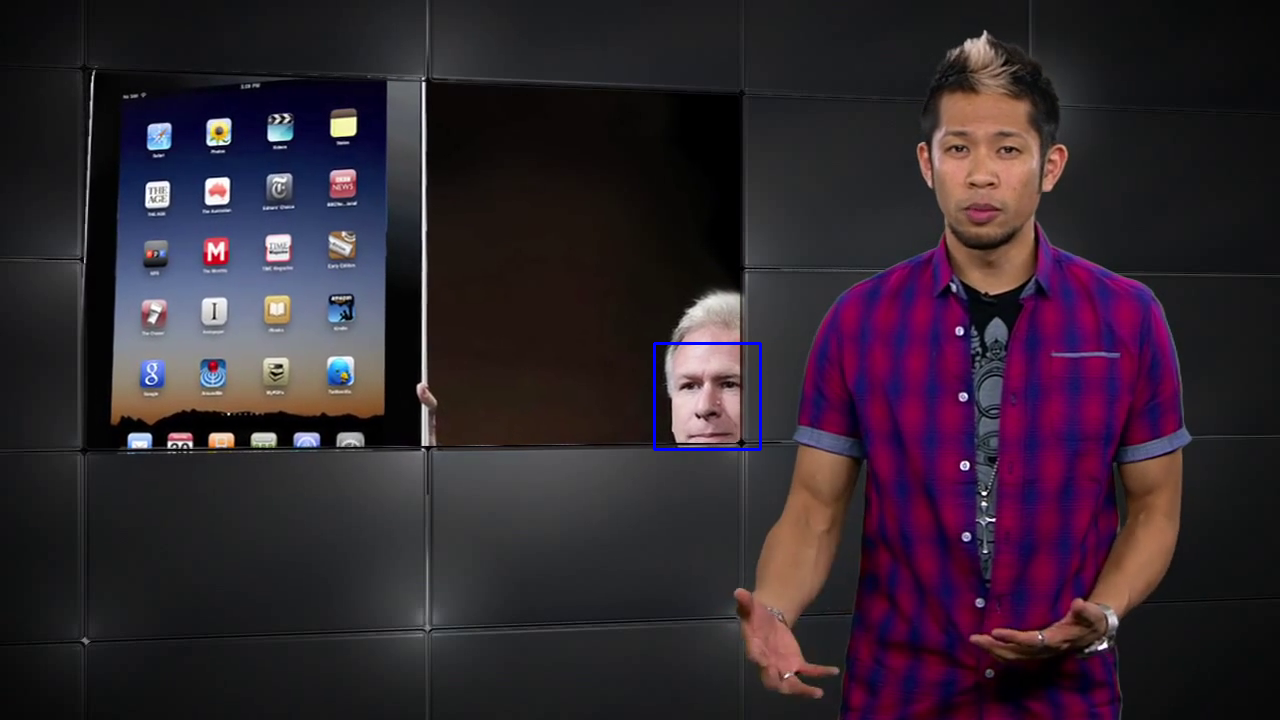

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


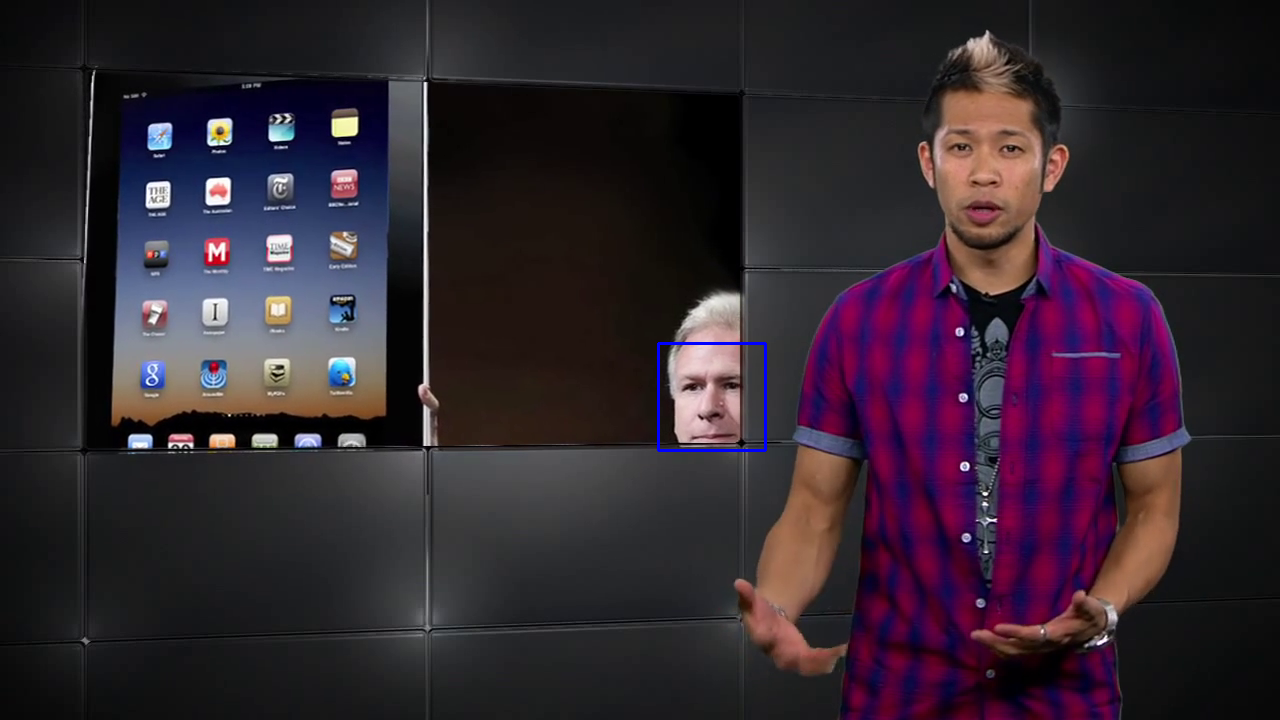

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


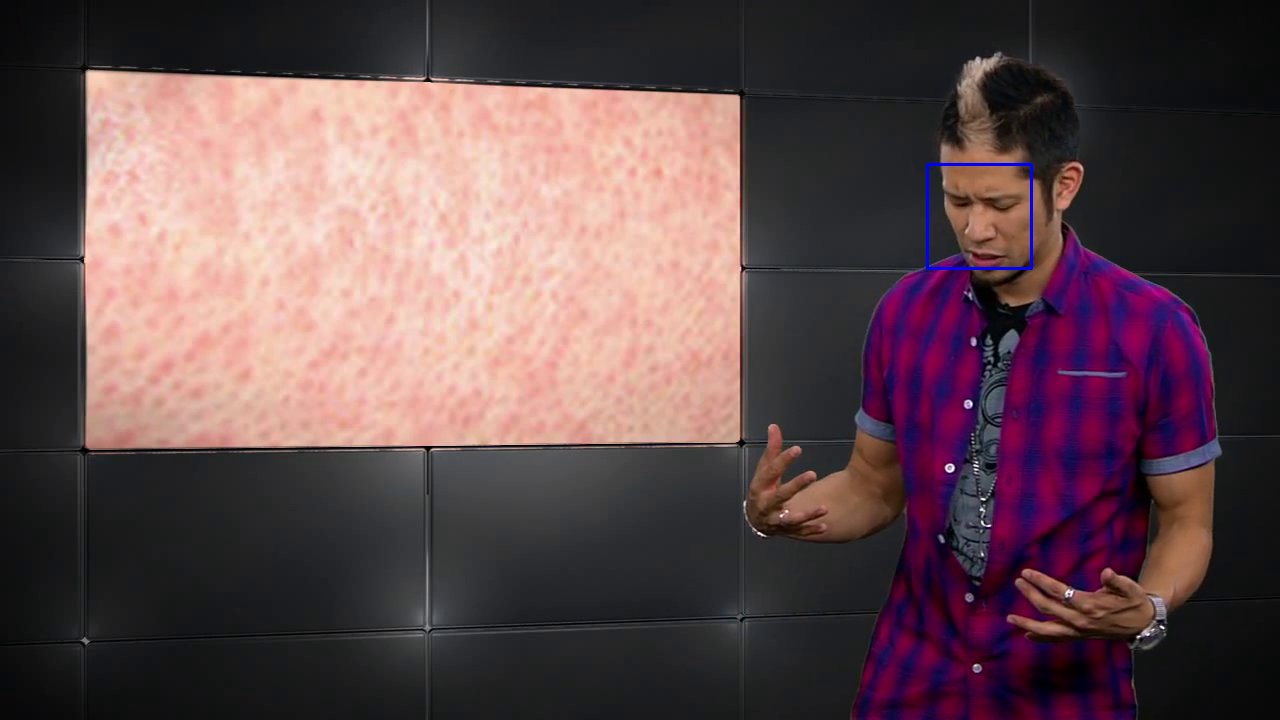

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


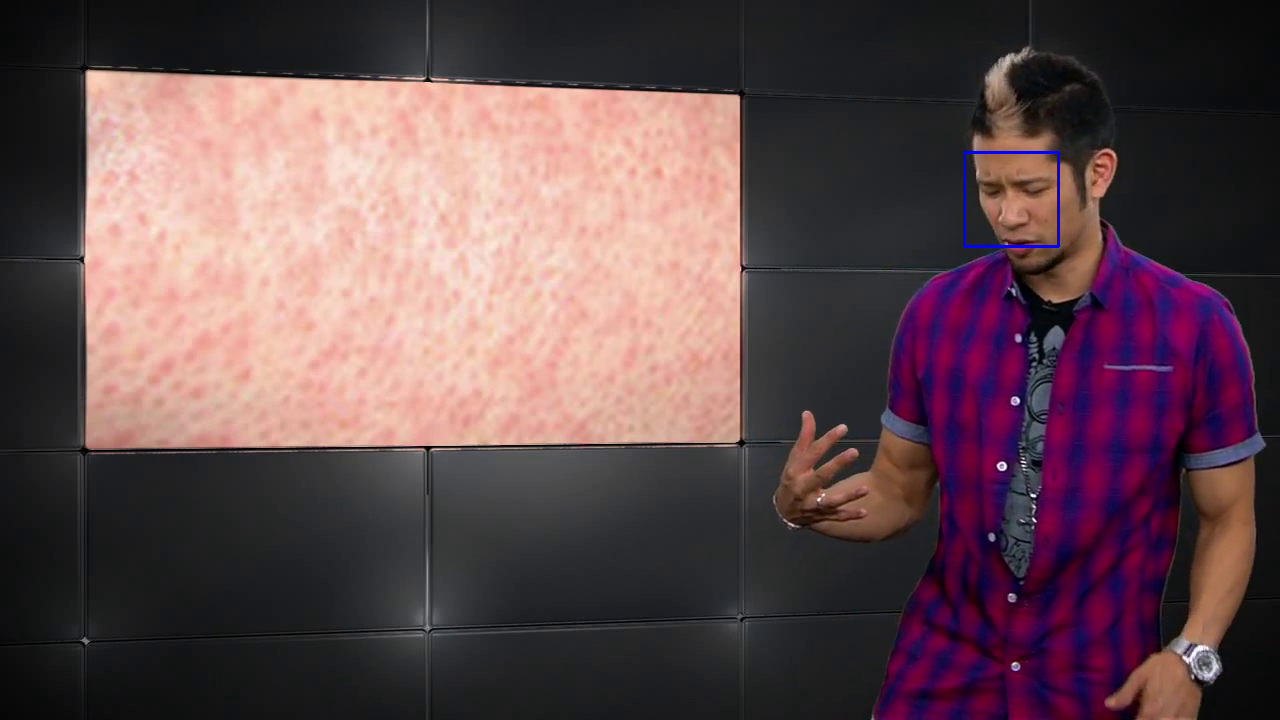

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


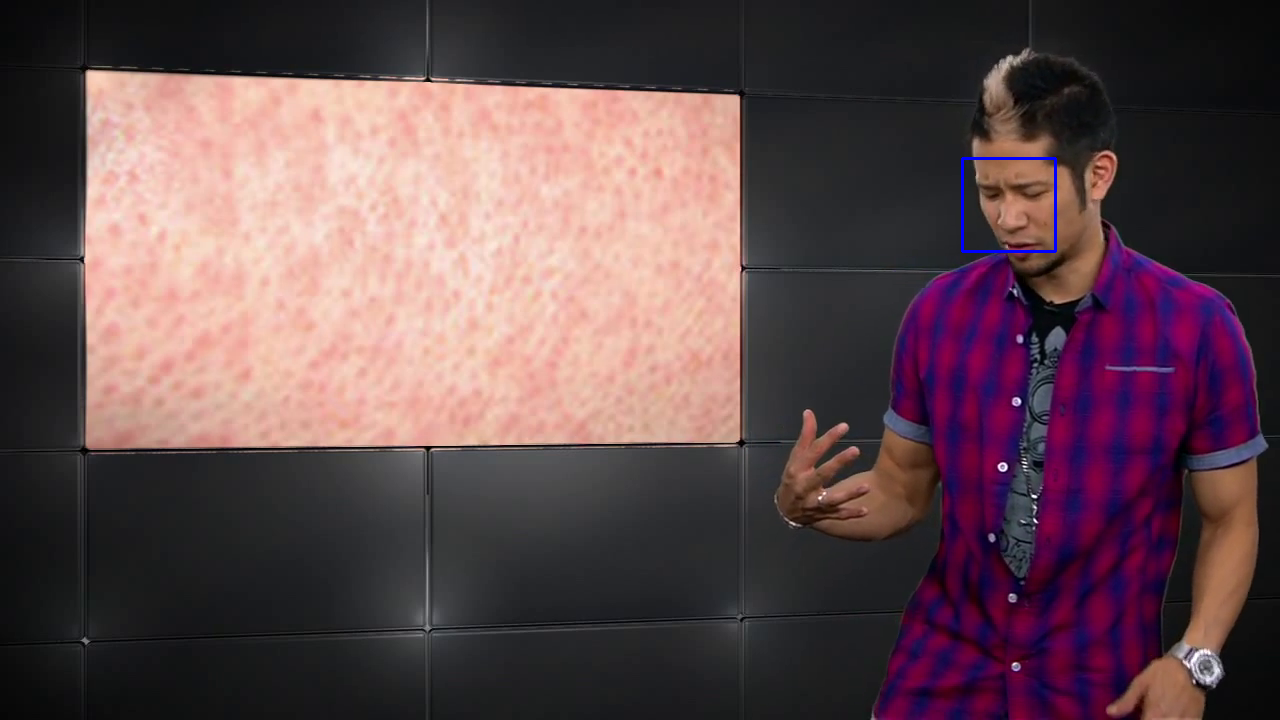

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


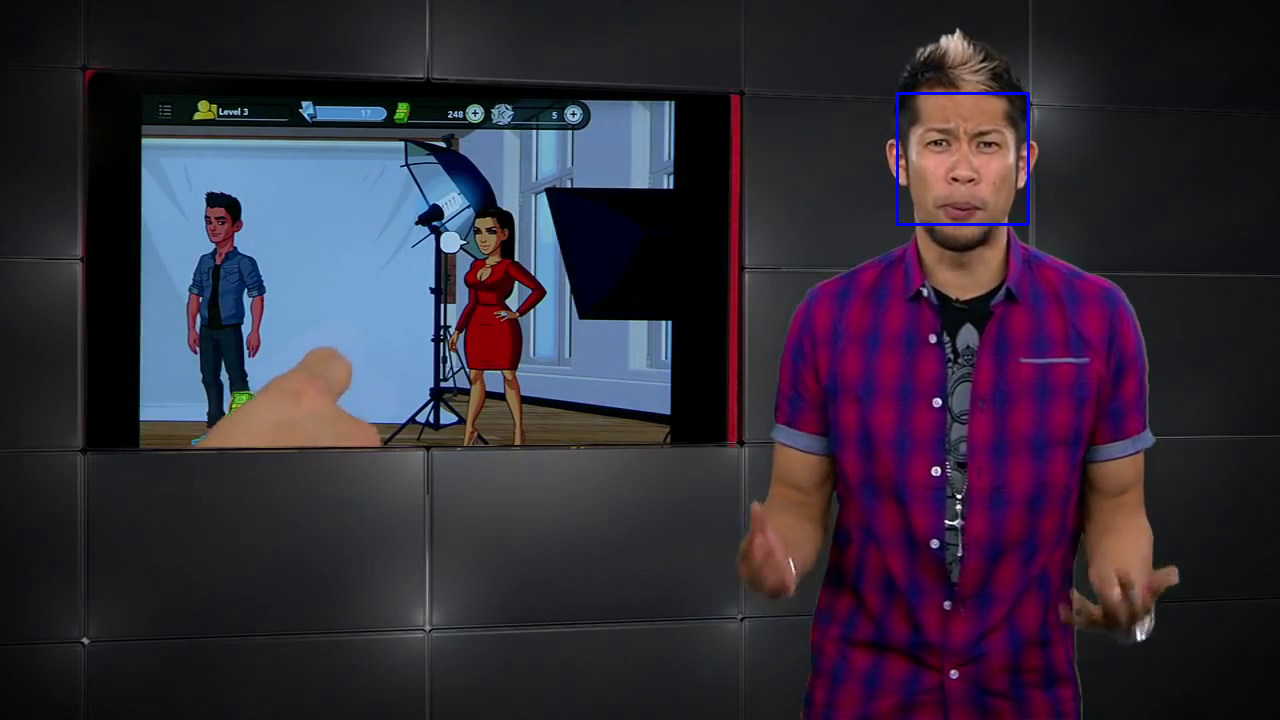

found,break forloop
before resize:(720, 1280, 3)
after resize:(360, 630, 3)


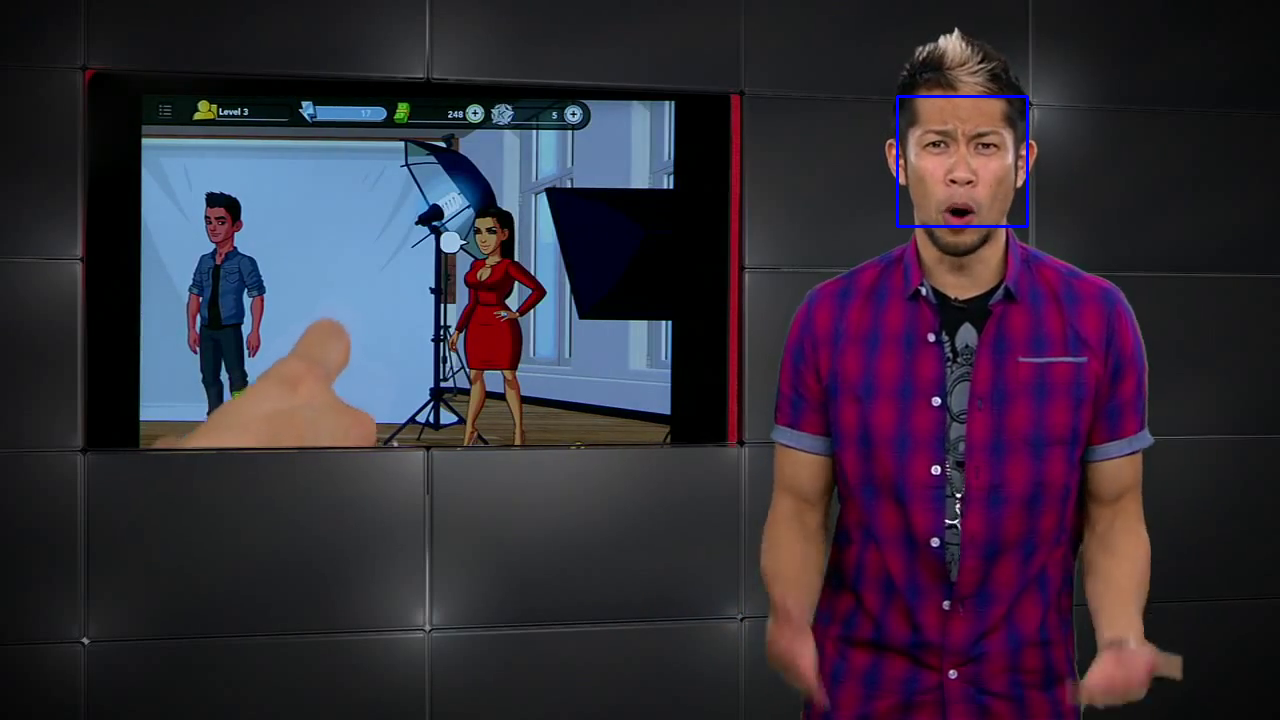

found,break forloop
frame not returned. False. close video output and cap
cap:True
cap:False
video_Out: True
video_out:False
cap is closed
video_out is close
link at the end after processing:https://www.youtube.com/watch?v=1WyWvhPHPWI
Number # 2video below.
video format info:
others:
link at the beginning before processinghttps://www.youtube.com/watch?v=UBPnLl2wmGc
deleted 1videos.
[youtube] UBPnLl2wmGc: Downloading webpage
[youtube] UBPnLl2wmGc: Downloading MPD manifest
[{'ext': 'm4a', 'format_note': 'DASH audio', 'acodec': 'mp4a.40.5', 'abr': 48, 'container': 'm4a_dash', 'format_id': '139', 'manifest_url': 'https://manifest.googlevideo.com/api/manifest/dash/expire/1609558070/ei/1pPvX8S_MdG1hwbHl5KoCQ/ip/34.86.29.206/id/5013e72e5db09867/source/youtube/requiressl/yes/playback_host/r5---sn-p5qs7nsr.googlevideo.com/mh/SC/mm/31%2C26/mn/sn-p5qs7nsr%2Csn-apn7en7e/ms/au%2Conr/mv/m/mvi/5/pl/20/hfr/all/as/fmp4_audio_clear%2Cwebm_audio_clear%2Cwebm2_audio_clear%2Cfmp4_sd_hd_clear%2Cwebm2_sd_hd_

[dashsegments] Total fragments: 36
[download] Destination: CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.f136.mp4
[download] 100% of 22.02MiB in 00:11
[dashsegments] Total fragments: 19
[download] Destination: CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.f251.webm
[download] 100% of 2.08MiB in 00:05
[ffmpeg] Merging formats into "CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.mkv"
Deleting original file CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.f136.mp4 (pass -k to keep)
Deleting original file CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.f251.webm (pass -k to keep)
glob /content/drive/My Drive/TestVideos/DownloadedVideos/CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.mkv  in youtubedl download
more than one video exist
print vlist:
['/content/drive/My Drive/TestVideos/DownloadedVideos/CNET Update - Apple CEO says sorry for iOS 6 map mess-UBPnLl2wmGc.mkv']

vlist l

[dashsegments] Total fragments: 54
[download] Destination: Googlicious - Is the Google watch coming soon-oCL7EogCGk8.f298.mp4
[download] 100% of 60.34MiB in 00:31
[dashsegments] Total fragments: 28
[download] Destination: Googlicious - Is the Google watch coming soon-oCL7EogCGk8.f251.webm
[download] 100% of 4.01MiB in 00:05
[ffmpeg] Merging formats into "Googlicious - Is the Google watch coming soon-oCL7EogCGk8.mkv"
Deleting original file Googlicious - Is the Google watch coming soon-oCL7EogCGk8.f298.mp4 (pass -k to keep)
Deleting original file Googlicious - Is the Google watch coming soon-oCL7EogCGk8.f251.webm (pass -k to keep)
glob /content/drive/My Drive/TestVideos/DownloadedVideos/Googlicious - Is the Google watch coming soon-oCL7EogCGk8.mkv  in youtubedl download
more than one video exist
print vlist:
['/content/drive/My Drive/TestVideos/DownloadedVideos/Googlicious - Is the Google watch coming soon-oCL7EogCGk8.mkv']

vlist len:1 get:/content/drive/My Drive/TestVideos/DownloadedVi

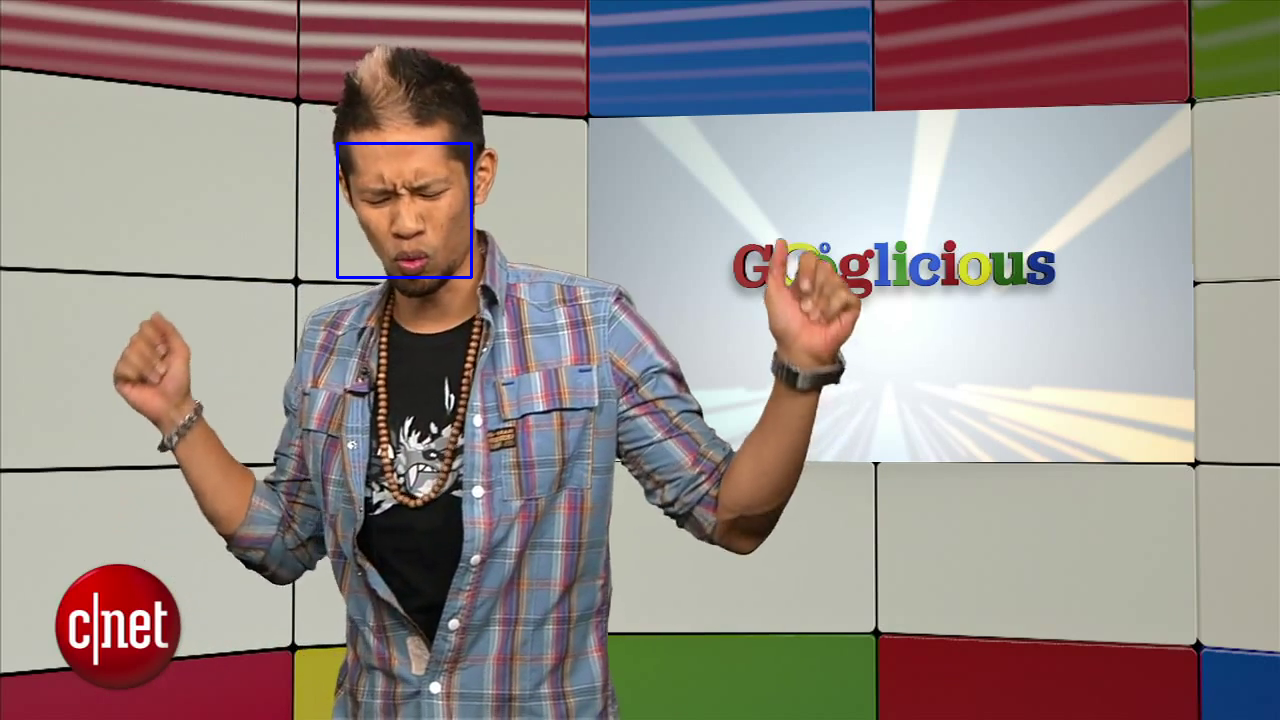

found,break forloop
frame not returned. False. close video output and cap
cap:True
cap:False
video_Out: True
video_out:False
cap is closed
video_out is close
link at the end after processing:https://www.youtube.com/watch?v=oCL7EogCGk8
Number # 4video below.
video format info:
others:
link at the beginning before processinghttps://www.youtube.com/watch?v=DgXdE5bXwKY
deleted 1videos.
[youtube] DgXdE5bXwKY: Downloading webpage
[youtube] DgXdE5bXwKY: Downloading MPD manifest
[{'ext': 'm4a', 'format_note': 'DASH audio', 'acodec': 'mp4a.40.5', 'abr': 48, 'container': 'm4a_dash', 'format_id': '139', 'manifest_url': 'https://manifest.googlevideo.com/api/manifest/dash/expire/1609561698/ei/AqLvX9_ML4iRhgb67JqABw/ip/34.86.29.206/id/0e05dd1396d7c0a6/source/youtube/requiressl/yes/playback_host/r1---sn-p5qlsndd.googlevideo.com/mh/QJ/mm/31%2C29/mn/sn-p5qlsndd%2Csn-p5qs7nsk/ms/au%2Crdu/mv/m/mvi/1/pl/20/hfr/all/as/fmp4_audio_clear%2Cwebm_audio_clear%2Cwebm2_audio_clear%2Cfmp4_sd_hd_clear%2Cwebm2_sd_hd_

[dashsegments] Total fragments: 33
[download] Destination: Tech gifts for dad-DgXdE5bXwKY.f298.mp4
[download] 100% of 37.49MiB in 00:12
[dashsegments] Total fragments: 17
[download] Destination: Tech gifts for dad-DgXdE5bXwKY.f251.webm
[download] 100% of 2.83MiB in 00:03
[ffmpeg] Merging formats into "Tech gifts for dad-DgXdE5bXwKY.mkv"
Deleting original file Tech gifts for dad-DgXdE5bXwKY.f298.mp4 (pass -k to keep)
Deleting original file Tech gifts for dad-DgXdE5bXwKY.f251.webm (pass -k to keep)
glob /content/drive/My Drive/TestVideos/DownloadedVideos/Tech gifts for dad-DgXdE5bXwKY.mkv  in youtubedl download
more than one video exist
print vlist:
['/content/drive/My Drive/TestVideos/DownloadedVideos/Tech gifts for dad-DgXdE5bXwKY.mkv']

vlist len:1 get:/content/drive/My Drive/TestVideos/DownloadedVideos/Tech gifts for dad-DgXdE5bXwKY.mkv
success at level 2 - d
cap info:
FOURCC code875967080.0
indicator:2
case 2 still write to video test
check, it should be open:True
exit set_video_out

Traceback (most recent call last):
  File "<ipython-input-57-a5c0a852544c>", line 6, in detect_parts
    rects = detector(gray,1)
KeyboardInterrupt
Traceback (most recent call last):
  File "<ipython-input-57-a5c0a852544c>", line 6, in detect_parts
    rects = detector(gray,1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-65-0f68f0af7c64>", line 58, in testResults
    distances = detect_parts(detected_face,detector,predictor)
  File "<ipython-input-57-a5c0a852544c>", line 15, in detect_parts
    raise RuntimeError("throw in detect_parts")
RuntimeError: throw in detect_parts


RuntimeError: ignored

In [ ]:
delete_angry_videos()
main()